# Building an Intake-esm catalog from CESM2 History Files

As mentioned in a couple of ESDS posts ([intake-esm and Dask](https://ncar.github.io/esds/posts/intake_esm_dask/), [debugging intake-esm](https://ncar.github.io/esds/posts/intake_cmip6_debug/)), [intake-esm](https://intake-esm.readthedocs.io/en/latest/) can be a helpful tool to work with when dealing with model data, especially CESM. One of the requirements for using intake-esm is having a catalog which is comprised of two pieces:
* A table of the relevant metadata (ex. file path, variable, stream, etc.)
* A json describing the dataset, including how to aggregate the variables

Typically, these pieces are constructed "manually" using information within the file path, on a very ad-hoc basis. Also, these catalogs are typically only created for "larger", community datasets, not neccessarily used within smaller model runs/daily workflows. A new package (currently a prototype), called [ecgtools](https://ecgtools.readthedocs.io/en/latest/) works to solve the issues of generating these intake-esm catalogs. Ecgtools stands for Earth System Model (ESM) Catalog Generation tools. The current catalog generation tools supported are:
* CMIP6 models
* CESM "history" files
* CESM "timeseries" files

This package has not officially been release yet on [pypi](https://pypi.org/) or [conda-forge](https://conda-forge.org/), but this release will likely happen soon. This post will give an overview of using [ecgtools](https://ecgtools.readthedocs.io/en/latest/) for parsing CESM history file model output, and reading in the data using 
[intake-esm](https://intake-esm.readthedocs.io/en/latest/). In this example, we use model output using the default component-set (compset) detailed in the [CESM Quickstart Guide](https://escomp.github.io/CESM/versions/cesm2.1/html/).

## What's a "history" file?
A history file is the default output from CESM, where each file is a single time "slice" with every variable from the component of interest. These types of files can be difficult to work with, since often times one is interested in a time series of a single variable. Building a catalog can be helpful in accessing your data, querying for certain variables, and potentially creating timeseries files later down the road.

Let's get started!

## Downloading the beta version of ecgtools
In order to access this in its current state, you will need to clone the repository from github. On the machine with the data you are planning on creating a catalog for, run the following:

```
git clone https://github.com/NCAR/ecgtools.git
```

This will create a clone of the repository on your machine. After you clone the respository, run

```
pip install -e ecgtools
```

This will install the package into the python environment you currently activated (for more on dealing with conda environments, check out the [faq page](https://ncar.github.io/esds/faq/#conda-environments)

You will also want to install intake-esm, which you can install using `conda-forge`

```
conda install -c conda-forge intake-esm
```

## Imports
The only parts of ecgtools we need are the `Builder` object and the `parse_cesm_history` parser from the CESM parsers! We import `glob` to take a look at the files we are parsing.

In [1]:
import glob

from ecgtools import Builder
from ecgtools.parsers.cesm import parse_cesm_history

### Understanding the Directory Structure

The first step to setting up the `Builder` object is determining where your files are stored. As mentioned previously, we have a sample dataset of CESM2 model output, which is stored in `/glade/work/mgrover/cesm_test_data/`

Taking a look at that directory, we see that there is a single case `b.e20.B1850.f19_g17.test`

In [2]:
glob.glob('/glade/work/mgrover/cesm_test_data/*')

['/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test']

Once we go into that directory, we see all the different components, including the atmosphere (atm), ocean (ocn), and land (lnd)!

In [3]:
glob.glob('/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/*')

['/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/logs',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/cpl',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/atm',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/ocn',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/lnd',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/esp',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/glc',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/rof',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/rest',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/wav',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/ice']

If we go one step further, we notice that within each component, is a `hist` directory which contains the model output

In [4]:
glob.glob('/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/atm/*/*.nc')[0:3]

['/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/atm/hist/b.e20.B1850.f19_g17.test.cam.h0.0002-08.nc',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/atm/hist/b.e20.B1850.f19_g17.test.cam.h0.0001-09.nc',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/atm/hist/b.e20.B1850.f19_g17.test.cam.h0.0002-07.nc']

If we take a look at the `ocn` component though, we notice that there are a few timeseries files in there...

In [5]:
glob.glob('/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/ocn/*/*.nc')[0:3]

['/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/ocn/tseries/b.e20.B1850.f19_g17.test.pop.h.pCO2SURF.000101-001012.nc',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/ocn/tseries/b.e20.B1850.f19_g17.test.pop.h.SiO3_RIV_FLUX.000101-001012.nc',
 '/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/ocn/tseries/b.e20.B1850.f19_g17.test.pop.h.graze_sp_zootot.000101-001012.nc']

When we setup our catalog builder, we will need to specify not including the timeseries (tseries) and restart (rest) directories!

Now that we understand the directory structure, let's make the catalog.

## Build the catalog!

Let's start by inspecting the builder object

In [6]:
?Builder

Init signature:
Builder(
    root_path: pydantic.types.DirectoryPath,
    extension: str = '.nc',
    depth: int = 0,
    exclude_patterns: List[str] = None,
    njobs: int = -1,
) -> None
Docstring:     
Generates a catalog from a list of files.

Parameters
----------
root_path : str
    Path of root directory.
extension : str, optional
    File extension, by default None. If None, the builder will look for files with
    "*.nc" extension.
depth : int, optional
    Recursion depth. Recursively crawl `root_path` up to a specified depth, by default 0
exclude_patterns : list, optional
    Directory, file patterns to exclude during catalog generation.
    These could be substring or regular expressions. by default None
njobs : int, optional
    The maximum number of concurrently running jobs,
    by default -1 meaning all CPUs are used.
File:           /glade/work/mgrover/git_repos/ecgtools/ecgtools/builder.py
Type:           type
Subclasses:     


<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Note that as of 21 June, 2021, the <code>parsing_func</code> parameter is now used in the <code>.build()</code> method!
</div>

In [7]:
b = Builder(
    # Directory with the output
    "/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/",
    # Depth of 1 since we are sending it to the case output directory
    depth=1,
    # Exclude the timeseries and restart directories
    exclude_patterns=["*/tseries/*", "*/rest/*"],
    # Number of jobs to execute - should be equal to # threads you are using
    njobs=5,
)

Double check the object is set up...

In [11]:
b

Builder(root_path=PosixPath('/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test'), extension='.nc', depth=1, exclude_patterns=['*/tseries/*', '*/rest/*'], njobs=5)

We are good to go! Let's build the catalog by calling `.build()` on the object, passing in the `parse_cesm_history` parser! By default, it will use the `LokyBackend` which is described in the [Joblib documentation](https://joblib.readthedocs.io/en/latest/parallel.html).

In [12]:
b = b.build(parse_cesm_history)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   6 out of  12 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=5)]: Done   9 out of  12 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  12 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  12 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   11.4s
[Parallel(n_jobs=5)]: Done 264 out of 264 | elapsed:   15.1s finished
/glade/work/mgrover/git_repos/ecgtools/ecgtools/builder.py:180: UserWarning: Unable to parse 5 assets/files. A list of these assets can be found in `.invalid_assets` attribute.
  parsing_func, parsing_func_kwargs


## Inspect the Catalog

Now that the catalog is built, we can inspect the dataframe which is used to create the catalog by calling `.df` on the builder object

In [13]:
b.df

,component,stream,case,date,frequency,variables,path
0,atm,cam.h0,b.e20.B1850.f19_g17.test,0002-08,month_1,"[date, datesec, date_written, time_written, nd...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
1,atm,cam.h0,b.e20.B1850.f19_g17.test,0001-09,month_1,"[date, datesec, date_written, time_written, nd...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
2,atm,cam.h0,b.e20.B1850.f19_g17.test,0002-07,month_1,"[date, datesec, date_written, time_written, nd...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
3,atm,cam.h0,b.e20.B1850.f19_g17.test,0003-05,month_1,"[date, datesec, date_written, time_written, nd...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
4,atm,cam.h0,b.e20.B1850.f19_g17.test,0002-01,month_1,"[date, datesec, date_written, time_written, nd...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
...,...,...,...,...,...,...,...
259,ice,cice.h,b.e20.B1850.f19_g17.test,0001-08,month_1,"[hi, hs, snowfrac, Tsfc, aice, uvel, vvel, uat...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
260,ice,cice.h,b.e20.B1850.f19_g17.test,0001-03,month_1,"[hi, hs, snowfrac, Tsfc, aice, uvel, vvel, uat...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
261,ice,cice.h,b.e20.B1850.f19_g17.test,0002-11,month_1,"[hi, hs, snowfrac, Tsfc, aice, uvel, vvel, uat...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
262,ice,cice.h,b.e20.B1850.f19_g17.test,0002-10,month_1,"[hi, hs, snowfrac, Tsfc, aice, uvel, vvel, uat...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...


The resultant dataframe includes the:
* Component
* Stream
* Case
* Date
* Frequency
* Variables
* Path

We can also check to see which files ***were not*** parsed by calling `.invalid_assets`

In [14]:
b.invalid_assets

,INVALID_ASSET,TRACEBACK
15,/glade/work/mgrover/cesm_test_data/b.e20.B1850...,"Traceback (most recent call last):\n File ""/g..."
28,/glade/work/mgrover/cesm_test_data/b.e20.B1850...,"Traceback (most recent call last):\n File ""/g..."
34,/glade/work/mgrover/cesm_test_data/b.e20.B1850...,"Traceback (most recent call last):\n File ""/g..."
130,/glade/work/mgrover/cesm_test_data/b.e20.B1850...,"Traceback (most recent call last):\n File ""/g..."
191,/glade/work/mgrover/cesm_test_data/b.e20.B1850...,"Traceback (most recent call last):\n File ""/g..."


In [15]:
b.invalid_assets.INVALID_ASSET.values[0]

PosixPath('/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/atm/hist/b.e20.B1850.f19_g17.test.cam.i.0002-01-01-00000.nc')

In [16]:
b.df

,component,stream,case,date,frequency,variables,path
0,atm,cam.h0,b.e20.B1850.f19_g17.test,0002-08,month_1,"[date, datesec, date_written, time_written, nd...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
1,atm,cam.h0,b.e20.B1850.f19_g17.test,0001-09,month_1,"[date, datesec, date_written, time_written, nd...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
2,atm,cam.h0,b.e20.B1850.f19_g17.test,0002-07,month_1,"[date, datesec, date_written, time_written, nd...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
3,atm,cam.h0,b.e20.B1850.f19_g17.test,0003-05,month_1,"[date, datesec, date_written, time_written, nd...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
4,atm,cam.h0,b.e20.B1850.f19_g17.test,0002-01,month_1,"[date, datesec, date_written, time_written, nd...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
...,...,...,...,...,...,...,...
259,ice,cice.h,b.e20.B1850.f19_g17.test,0001-08,month_1,"[hi, hs, snowfrac, Tsfc, aice, uvel, vvel, uat...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
260,ice,cice.h,b.e20.B1850.f19_g17.test,0001-03,month_1,"[hi, hs, snowfrac, Tsfc, aice, uvel, vvel, uat...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
261,ice,cice.h,b.e20.B1850.f19_g17.test,0002-11,month_1,"[hi, hs, snowfrac, Tsfc, aice, uvel, vvel, uat...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...
262,ice,cice.h,b.e20.B1850.f19_g17.test,0002-10,month_1,"[hi, hs, snowfrac, Tsfc, aice, uvel, vvel, uat...",/glade/work/mgrover/cesm_test_data/b.e20.B1850...


It appears that one of the invalid assets is a `pop.hv` stream, which is a time-invariant dataset we would not neccessarily be interested in looking at. If there is a file you think ***should*** be included in the resultant catalog but isn't, be sure to add it to the `_STREAMS_DICT` used in the [parsing tool](https://github.com/NCAR/ecgtools/blob/main/ecgtools/parsers/cesm.py)! 

## Save the Catalog

In [17]:
b.save(
    # File path - could save as .csv (uncompressed csv) or .csv.gz (compressed csv)
    "/glade/work/mgrover/cesm-hist-test.csv",
    # Column name including filepath
    path_column_name='path',
    # Column name including variables
    variable_column_name='variables',
    # Data file format - could be netcdf or zarr (in this case, netcdf)
    data_format="netcdf",
    # Which attributes to groupby when reading in variables using intake-esm
    groupby_attrs=["component", "stream", "case"],
    # Aggregations which are fed into xarray when reading in data using intake
    aggregations=[
        {
            "type": "join_existing",
            "attribute_name": "date",
            "options": {"dim": "time", "coords": "minimal", "compat": "override"},
        }
    ],
)

Saved catalog location: /glade/work/mgrover/cesm-hist-test.json and /glade/work/mgrover/cesm-hist-test.csv


/glade/u/home/mgrover/miniconda3/envs/hires-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Unable to parse 5 assets/files. A list of these assets can be found in /glade/work/mgrover/invalid_assets_cesm-hist-test.csv.


## Using the Catalog

You'll notice the resultant filepaths are output when calling `.save` - which you could use within your intake-esm `open_esm_datastore` function.

### Additional Imports

In [18]:
# Import ast which helps with parsing the list of variables
import ast

# Import intake-esm
import intake

### Use the catalog to read in data

In [19]:
col = intake.open_esm_datastore(
    "/glade/work/mgrover/cesm-hist-test.json",
    csv_kwargs={"converters": {"variables": ast.literal_eval}},
    sep="/",
)
col

,unique
component,6
stream,9
case,1
date,79
frequency,4
variables,1447
path,259


In [20]:
cat = col.search(
    variables='TEMP',
)
cat

,unique
component,1
stream,1
case,1
date,36
frequency,1
variables,434
path,36


In [21]:
dsets = cat.to_dataset_dict(cdf_kwargs={'use_cftime': True, 'chunks': {'time': 10}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component/stream/case'


In [23]:
dsets

{'ocn/pop.h/b.e20.B1850.f19_g17.test': <xarray.Dataset>
 Dimensions:  (nlat: 384, nlon: 320, time: 36, z_t: 60)
 Coordinates:
   * time     (time) object 0004-01-01 00:00:00 ... 0002-03-01 00:00:00
   * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
     ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
 Dimensions without coordinates: nlat, nlon
 Data variables:
     TEMP     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
 Attributes:
     intake_esm_varname:      ['TEMP']
     source:                  CCSM POP2, the CCSM Ocean Component
     time_period_freq:        month_1
     calendar:                All years have exactly  365 days.
    

Let's plot a quick figure from the dataset!

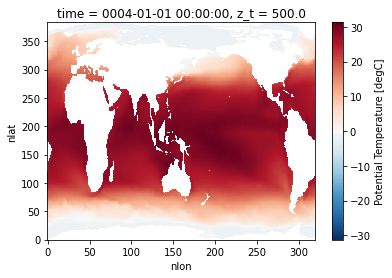

In [24]:
dsets['ocn/pop.h/b.e20.B1850.f19_g17.test'].TEMP.isel(time=0, z_t=0).plot();

## Conclusion
Having the ability to easily create intake-esm catalogs from history files can be a powerful tool in your analysis toolkit. These data can be read in relatively quickly, easing the ability to quickly take a look at model output or even share your data with others! For more updates on [ecgtools](https://github.com/NCAR/ecgtools), be sure to follow [the ecgtools repository](https://github.com/NCAR/ecgtools) on Github! Have an idea for another helpful parser? Submit an issue!